In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai.vision import *

In [3]:
data = range(1000)

In [5]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix-n_steps+1:end_ix+1]
        X.append(seq_x)
        y.append(seq_y)
    return tensor(X).float(), tensor(y).float()

In [6]:
n_steps = 3
X, y = split_sequence(data,n_steps)

In [7]:
def head(X,y):
    for i in range(5):
        print(X[i], y[i])

In [8]:
head(X,y)

tensor([0., 1., 2.]) tensor([1., 2., 3.])
tensor([1., 2., 3.]) tensor([2., 3., 4.])
tensor([2., 3., 4.]) tensor([3., 4., 5.])
tensor([3., 4., 5.]) tensor([4., 5., 6.])
tensor([4., 5., 6.]) tensor([5., 6., 7.])


In [26]:
bs=12
class Model(nn.Module):
    def __init__(self,n_in, nh, n_out, bs):
        super().__init__()
        self.rnn = nn.RNN(n_in, nh, batch_first=True)  #<--(bs, seq, features)
        self.h_o = nn.Linear(nh,n_out)
        self.bn = BatchNorm1dFlat(nh)
        self.h = torch.zeros(1, bs, nh).cuda()
        
    def forward(self, x):
        res,h = self.rnn(x, self.h)
        self.h = h.detach()
        return self.h_o(self.bn(res))

In [27]:
model = Model(1, 50, 1, bs)

In [28]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))

In [29]:
X.shape, y.shape

(torch.Size([997, 3, 1]), torch.Size([997, 3, 1]))

In [30]:
x0 = X[0];
x0 = x0[None,:]; x0.shape

torch.Size([1, 3, 1])

In [31]:
model.rnn(x0)[0].shape

torch.Size([1, 3, 50])

In [32]:
model.bn(model.rnn(x0)[0]).shape

torch.Size([1, 3, 50])

In [33]:
model.h_o(model.bn(model.rnn(x0)[0])).shape

torch.Size([1, 3, 1])

In [38]:
idx = int(0.8*len(X))
ds_train = TensorDataset(X[0:idx],y[0:idx])
ds_valid = TensorDataset(X[idx:],y[idx:])

dl_train = DataLoader(ds_train, bs, drop_last=True)
dl_valid = DataLoader(ds_valid, bs, drop_last=True)

db = fastai.basic_data.DataBunch(dl_train, dl_valid)

learn = fastai.basic_train.Learner(db, 
                                   model, 
                                   loss_func=nn.MSELoss())

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


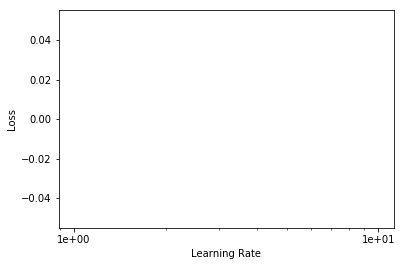

In [39]:
learn.lr_find(); learn.recorder.plot()

In [41]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,time
0,281163.031250,807241.312500,00:00
1,280581.531250,788890.812500,00:00
2,279406.656250,777057.000000,00:00
3,278395.875000,698813.750000,00:00
4,277936.812500,654637.562500,00:00


In [42]:
p,t=learn.get_preds()

In [43]:
p[0], t[0]

(tensor([[57.7272],
         [58.1122],
         [58.8675]]), tensor([[798.],
         [799.],
         [800.]]))

In [108]:
def dropout_mask(x, sz, p):
    return x.new(sz).bernoulli_(1-p).div_(1-p)

class rnn_dropout(nn.Module):
    'Dropout consistent on the time axis'
    def __init__(self, p=0.3):
        super().__init__()
        self.p = p
        
    def forward(self, x):
        if not self.training or self.p == 0 : return x
        m = dropout_mask(x.data, torch.Size((x.size(0), 1, x.size(2))), self.p)
        return m*x

class lm(nn.Module):
    def __init__(self, n_in, nh, n_out, ncl, dp):
        super().__init__()
        self.encode = nn.LSTM(n_in,nh, batch_first=True)
        self.cores = nn.ModuleList([nn.LSTM(nh, nh, batch_first=True) for _ in range(ncl)])
        self.drops = nn.ModuleList([rnn_dropout(dp) for _ in range(ncl)])
        self.decode = nn.Linear(nh, n_out)
        
    def forward(self, x):
        x = self.encode(x)[0]
        for core, drop in zip(self.cores, self.drops):
            x = drop(core(x)[0])
        x = self.decode(x)
        return x

In [109]:
model2 = lm(n_in = 1, nh = 64, n_out = 1, ncl = 3, dp = 0.01).cuda()

In [110]:
learn2 = fastai.basic_train.Learner(db, 
                                   model2, 
                                   loss_func=nn.MSELoss())

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


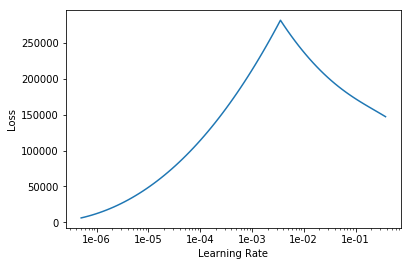

In [112]:
learn2.lr_find(1e-7,1, stop_div=False); learn2.recorder.plot()

In [81]:
learn2.fit(5, 1e-2)

epoch,train_loss,valid_loss,time
0,4859955748274176.000000,4782501381799936.000000,00:01
1,4747900588392448.000000,4644566359605248.000000,00:01


KeyboardInterrupt: 

In [315]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = torch.zeros(input.size(0), 51, dtype=torch.double).cuda()
        c_t = torch.zeros(input.size(0), 51, dtype=torch.double).cuda()
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double).cuda()
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double).cuda()

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [323]:
np.random.seed(2)

T = 20
L = 1000
N = 1000

x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x / 1.0 / T).astype('float64')
torch.save(data, open('traindata.pt', 'wb'))

In [324]:
np.random.seed(0)
torch.manual_seed(0)
# load data and make training set
data = torch.load('traindata.pt')
input = torch.from_numpy(data[3:, :-1])
target = torch.from_numpy(data[3:, 1:])
test_input = torch.from_numpy(data[:3, :-1])
test_target = torch.from_numpy(data[:3, 1:])
# build the model
seq = Sequence().double()

In [325]:
input.shape, target.shape

(torch.Size([997, 999]), torch.Size([997, 999]))

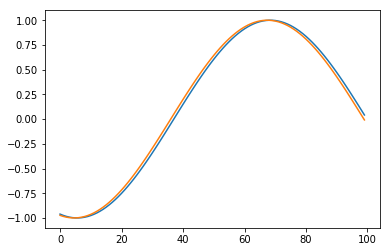

In [326]:
plt.plot(input[0,0:100])
plt.plot(target[0,0:100])

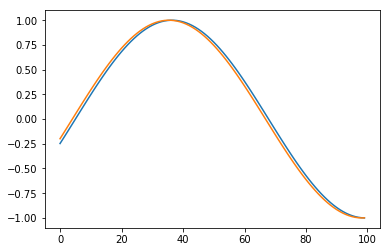

In [327]:
plt.plot(input[1,0:100])
plt.plot(target[1,0:100])

In [331]:
ds_train = TensorDataset(input,target)
ds_valid = TensorDataset(test_input,test_target)

dl_train = DataLoader(ds_train, 128)
dl_valid = DataLoader(ds_valid, 64)

db = fastai.basic_data.DataBunch(dl_train, dl_valid)

learn = fastai.basic_train.Learner(db, 
                                   seq, 
                                   loss_func=nn.MSELoss())

In [332]:
learn.fit(1)

epoch,train_loss,valid_loss,time
0,0.016768,0.007895,00:15


In [333]:
p,t = learn.get_preds()

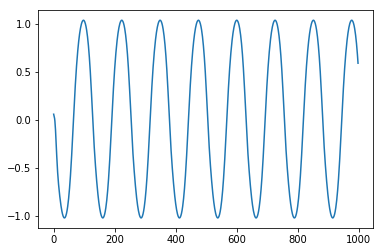

In [336]:
plt.plot(p[0])

In [311]:

criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)
#begin to train
for i in range(15):
    print('STEP: ', i)
    def closure():
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
        print('loss:', loss.item())
        loss.backward()
        return loss
    optimizer.step(closure)
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        future = 1000
        pred = seq(test_input, future=future)
        loss = criterion(pred[:, :-future], test_target)
        print('test loss:', loss.item())
        y = pred.detach().numpy()
    # draw the result
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    def draw(yi, color):
        plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
        plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
    draw(y[0], 'r')
    draw(y[1], 'g')
    draw(y[2], 'b')
    plt.savefig('predict%d.pdf'%i)
    plt.close()

STEP:  0
loss: 0.5023738122475343
loss: 0.4985663937943548
loss: 0.47901196061153817
loss: 0.44633490214842186
loss: 0.3540631025749384
loss: 0.2050701661768073
loss: 1.3960531561167067
loss: 0.03249441148471867
loss: 0.029934875839601752
loss: 0.028326821011534383
loss: 0.02683061221882407
loss: 0.02377120198998949
loss: 0.018901413504544384
loss: 0.010646818233205737
loss: 0.00872575209026843
loss: 0.007872181287777094
loss: 0.005477842749594561
loss: 0.004051933564064109
loss: 0.002729622701158991
loss: 0.0015402652769805328
test loss: 0.0013000876156953937
STEP:  1
loss: 0.001279764616782598
loss: 0.0011690554954715225
loss: 0.0011498916013726185
loss: 0.0011288245291280234
loss: 0.0010630561341025558
loss: 0.0009564006443284911
loss: 0.0008210827589986387
loss: 0.0007670796029144074
loss: 0.0007294716423577023
loss: 0.0007246558169809817
loss: 0.0007206211393647143
loss: 0.000712668605310463


KeyboardInterrupt: 